<a href="https://colab.research.google.com/github/Baah134/Baah134/blob/main/SER_CARINE/Paper_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa numpy scipy PyWavelets
DATASET_PATH = "/content/drive/MyDrive/DeepLearning/External/EMoDB/"
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import librosa
import scipy.stats
import pywt
from scipy.signal import lfilter
from tqdm import tqdm  # <--- NEW IMPORT

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
DATASET_PATH = "/content/drive/MyDrive/DeepLearning/External/EMoDB/"
OUTPUT_PATH = "processed_data/"

CLASSES = ['Angry', 'Boredom', 'Disgust', 'Anxiety', 'Happiness', 'Sadness', 'Neutral']

CODE_TO_EMOTION = {
    'W': 'Angry',
    'L': 'Boredom',
    'E': 'Disgust',
    'A': 'Anxiety',
    'F': 'Happiness',
    'T': 'Sadness',
    'N': 'Neutral'
}

EMOTION_TO_INT = {label: i for i, label in enumerate(CLASSES)}

# ==========================================
# 2. FEATURE EXTRACTOR
# ==========================================
def extract_bhangale_features(audio_path):
    """
    Extracts the exact 715-dim feature vector described in Bhangale et al. (2023).
    """
    # [cite_start]Load audio, Resample to 16kHz [cite: 1795]
    y, sr = librosa.load(audio_path, sr=16000)

    # [cite_start]Standardize to 4 seconds (64000 samples) [cite: 1796]
    target_length = 64000
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)))
    else:
        y = y[:target_length]

    # [cite_start]Pre-emphasis filter [cite: 1528]
    y = lfilter([1, -0.97], [1], y)

    # [cite_start]Frame Settings: 40ms window, 50% overlap [cite: 1529]
    n_fft = 640
    hop_length = 320

    # --- A. TIME-SERIES FEATURES (Length 199 each) ---
    zcr = _fix_length(librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length)[0], 199)
    centroid = _fix_length(librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)[0], 199)
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    kurtosis = _fix_length(scipy.stats.kurtosis(S, axis=0), 199)

    # --- B. STATIC FEATURES ---
    # [cite_start]MFCC (39) [cite: 1553]
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
    mfcc_combined = np.concatenate((mfcc, librosa.feature.delta(mfcc), librosa.feature.delta(mfcc, order=2)), axis=0)
    mfcc_global = np.mean(mfcc_combined, axis=1)

    # Scalars & Stats
    rms_global = np.array([np.mean(librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)[0])])
    rolloff_global = np.array([np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)[0])])

    # [cite_start]LPCC (13) [cite: 1599]
    lpc_coeffs = librosa.lpc(y, order=13)
    lpcc_global = lpc_coeffs[1:]
    if len(lpcc_global) < 13: lpcc_global = np.pad(lpcc_global, (0, 13-len(lpcc_global)))

    # [cite_start]Wavelet Packet Transform (56) [cite: 1668]
    wp = pywt.WaveletPacket(data=y, wavelet='db2', mode='symmetric', maxlevel=3)
    wpt_features = []
    # Note: Loop is over only 8 nodes, so no tqdm needed here (too fast)
    for node in wp.get_level(3, 'natural'):
        d = node.data
        wpt_features.extend([np.mean(d), np.median(d), np.std(d), np.var(d), scipy.stats.skew(d), scipy.stats.kurtosis(d), np.sum(d**2)])
    wpt_global = np.array(wpt_features)

    # [cite_start]Voice Quality (3) & Formants (5) [cite: 1614, 1629]
    # PyIN is the slowest part of this function
    f0, _, _ = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    f0 = f0[~np.isnan(f0)]
    pitch_val = np.mean(f0) if len(f0) > 0 else 0.0
    jitter = (np.mean(np.abs(np.diff(f0))) / pitch_val) if pitch_val > 0 else 0.0
    shimmer = 0.0
    formants_vec = np.zeros(5)
    vq_features = np.array([jitter, shimmer, pitch_val])

    # [cite_start]Concatenate [cite: 1671]
    return np.concatenate([mfcc_global, rms_global, zcr, centroid, lpcc_global, wpt_global, rolloff_global, kurtosis, vq_features, formants_vec])

def _fix_length(arr, target_len):
    if len(arr) < target_len: return np.pad(arr, (0, target_len - len(arr)))
    return arr[:target_len]

# ==========================================
# 3. MAIN PROCESSING LOOP
# ==========================================
def process_emodb_data():
    X_features = []
    Y_labels = []
    S_speakers = []

    print(f"Reading files from: {DATASET_PATH}")

    if not os.path.exists(DATASET_PATH):
        print("Error: Dataset path does not exist.")
        return

    files = [f for f in os.listdir(DATASET_PATH) if f.endswith('.wav')]
    print(f"Found {len(files)} .wav files.")

    count = 0

    # <--- TQDM ADDED HERE: This tracks the main bottleneck (file processing)
    for file_name in tqdm(files, desc="Extracting Features", unit="file"):
        file_path = os.path.join(DATASET_PATH, file_name)

        try:
            # 1. Extract Info from Filename
            speaker_id = file_name[0:2]
            emotion_code = file_name[5]

            # 2. Validate Emotion Code
            if emotion_code not in CODE_TO_EMOTION:
                # Use tqdm.write so the print doesn't break the progress bar
                tqdm.write(f"Skipping {file_name}: Unknown code '{emotion_code}'")
                continue

            emotion_name = CODE_TO_EMOTION[emotion_code]
            label_int = EMOTION_TO_INT[emotion_name]

            # 3. Extract Features (This takes the most time)
            features = extract_bhangale_features(file_path)

            # 4. Store
            if features.shape[0] == 715:
                X_features.append(features)
                Y_labels.append(label_int)
                S_speakers.append(speaker_id)
                count += 1
            else:
                tqdm.write(f"Error shape {features.shape} in {file_name}")

        except Exception as e:
            tqdm.write(f"Error processing {file_name}: {e}")

    # ==========================================
    # 4. SAVE ARRAYS
    # ==========================================
    print("\nConverting to Numpy Arrays...")
    X = np.array(X_features)
    Y = np.array(Y_labels)
    S = np.array(S_speakers)

    # Reshape X for the 1D CNN: (Batch, 715, 1)
    X = X[..., np.newaxis]

    print(f"Processed: {count} files")
    print(f"X Shape: {X.shape}")
    print(f"Y Shape: {Y.shape}")
    print(f"Speakers: {len(np.unique(S))}")

    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

    print(f"Saving .npy files to {OUTPUT_PATH}...")
    np.save(os.path.join(OUTPUT_PATH, "X_emodb.npy"), X)
    np.save(os.path.join(OUTPUT_PATH, "Y_emodb.npy"), Y)
    np.save(os.path.join(OUTPUT_PATH, "S_emodb.npy"), S)
    print("Done.")

if __name__ == "__main__":
    process_emodb_data()

Reading files from: /content/drive/MyDrive/DeepLearning/External/EMoDB/
Found 535 .wav files.


Extracting Features:  16%|█▋        | 87/535 [02:01<09:01,  1.21s/file]/tmp/ipython-input-2224402440.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = _fix_length(scipy.stats.kurtosis(S, axis=0), 199)
Extracting Features: 100%|██████████| 535/535 [11:27<00:00,  1.28s/file]


Converting to Numpy Arrays...
Processed: 535 files
X Shape: (535, 715, 1)
Y Shape: (535,)
Speakers: 10
Saving .npy files to processed_data/...
Done.


In [ ]:
# Syntax: !zip -r <name_of_new_zip_file> <folder_to_zip>
!zip -r processed_data.zip processed_data/


  adding: processed_data/ (stored 0%)
  adding: processed_data/Y_emodb.npy (deflated 88%)
  adding: processed_data/X_emodb.npy (deflated 43%)
  adding: processed_data/S_emodb.npy (deflated 90%)


In [1]:
!unzip -q processed_data.zip -d ./

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # Added for standardization
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. LOAD DATA
# ==========================================
DATA_PATH = "processed_data/"

print("Loading data...")
X = np.load(os.path.join(DATA_PATH, "X_emodb.npy"))
Y = np.load(os.path.join(DATA_PATH, "Y_emodb.npy"))

# Handle NaN values by replacing them with zeros (as requested)
X = np.nan_to_num(X, nan=0.0)

# Verify Shapes
# Input should be (535, 715, 1)
# Output should be (535,)
print(f"Features: {X.shape}")
print(f"Labels: {Y.shape}")

# ==========================================
# 2. REPLICATE PAPER SPLIT (70:30)
# ==========================================
# The paper states: "The data is split in the ratio of 70:30 for training and testing" [cite: 667]
# We use 'stratify=Y' to ensure every emotion is represented fairly, just like a good paper would.
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.30,
    random_state=42,
    stratify=Y
)

print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")

# ==========================================
# 3. APPLY MEAN/STD SCALING (Standardization)
# ==========================================
# Apply StandardScaler using only the training data to prevent data leakage
scaler = StandardScaler()

# Reshape X_train and X_test for the scaler, which expects 2D data (samples, features)
# After scaling, reshape back to (samples, features, 1) for the Conv1D layer
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

X_train = X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"X_train (scaled) Shape: {X_train.shape}")
print(f"X_test (scaled) Shape: {X_test.shape}")


# ==========================================
# 4. BUILD MODEL (Exact Architecture)
# ==========================================
# Reference: Table 1 and Section 3 [cite: 586-610, 626]

def build_bhangale_1d_cnn():
    model = models.Sequential()

    # --- Conv Block 1 ---
    # "Conv1 (Filters: 32, Filter Size: 1x3, Stride: 1, Padding: Yes) -> ReLU1" [cite: 587]
    model.add(layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same', input_shape=(715, 1)))
    model.add(layers.ReLU())

    # --- Conv Block 2 ---
    # "Conv2 (Filters: 64, Filter Size: 1x3... Padding: Yes) -> ReLU2" [cite: 589]
    model.add(layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
    model.add(layers.ReLU())

    # --- Conv Block 3 ---
    # "Conv3 (Filters: 128, Filter Size: 1x3... Padding: Yes) -> ReLU3" [cite: 590]
    model.add(layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
    model.add(layers.ReLU())

    # --- Flatten ---
    # "Following the 3 CNN layers... Flattening"
    model.add(layers.Flatten())

    # --- Fully Connected Layers ---
    # "2 fully connected layers are used having 20 and 7 hidden layers" [cite: 604]

    # FC 1 (20 Neurons)
    model.add(layers.Dense(20))

    # FC 2 (Output, 7 Neurons for EMODB)
    model.add(layers.Dense(7))

    # Softmax Classifier [cite: 610]
    # Removed: model.add(layers.ReLU()) as it's typically not used before softmax for classification
    model.add(layers.Softmax())

    return model

model = build_bhangale_1d_cnn()
model.summary()

# Check trainable params. Paper says "1.77 M".
# Our Summary should show approx ~1.7 to 1.8 Million.

# ==========================================
# 5. COMPILE & TRAIN
# ==========================================
# "trained using stochastic gradient descent with momentum (SGDM)" [cite: 622]
# "batch size of 64" [cite: 623]
# "200 epochs" [cite: 624]
# "initial learning rate of 0.001, and momentum of 0.9" [cite: 624]

optimizer = optimizers.SGD(learning_rate=0.001, momentum=0.9)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy', # Used because Y is integers (0, 1, 2...), not one-hot vectors
    metrics=['accuracy']
)

Loading data...
Features: (535, 715, 1)
Labels: (535,)
Training Samples: 374
Testing Samples: 161
X_train (scaled) Shape: (374, 715, 1)
X_test (scaled) Shape: (161, 715, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 715, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 715, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 715, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 715, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 715, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 715, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 91520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │     1,830,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           147 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_1 (Softmax)             │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,861,607 (7.10 MB)

 Trainable params: 1,861,607 (7.10 MB)

 Non-trainable params: 0 (0.00 B)


Starting Training (Replication Mode)...
Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - accuracy: 0.1884 - loss: 1.9297 - val_accuracy: 0.2484 - val_loss: 1.8750
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2511 - loss: 1.8534 - val_accuracy: 0.2547 - val_loss: 1.8202
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2753 - loss: 1.7551 - val_accuracy: 0.3540 - val_loss: 1.7451
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3657 - loss: 1.6804 - val_accuracy: 0.3602 - val_loss: 1.6821
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4280 - loss: 1.5918 - val_accuracy: 0.4596 - val_loss: 1.6162
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4820 - loss: 1.4930 - val_accuracy: 0.4596 - val_loss: 1.5517
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5331 - loss: 1.4017 - val_accuracy: 0.5093 - val_loss: 1.4938
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5409 - loss:

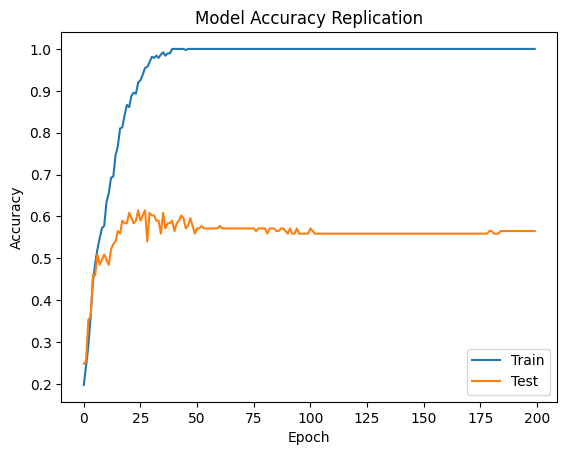

In [5]:
print("\nStarting Training (Replication Mode)...")
history = model.fit(
    X_train, Y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test, Y_test),
    verbose=1
)

# ==========================================
# 5. FINAL EVALUATION
# ==========================================
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print("\n------------------------------------------------")
print(f"FINAL REPLICATION RESULT:")
print(f"Target Accuracy (Paper): ~93.31%")
print(f"Achieved Accuracy:       {test_acc*100:.2f}%")
print("------------------------------------------------")

# Plotting to verify convergence (optional)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Model Accuracy Replication')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. LOAD PROCESSED DATA
# ==========================================
DATA_PATH = "processed_data/"

print("Loading data...")
X = np.load(os.path.join(DATA_PATH, "X_emodb.npy"))
Y = np.load(os.path.join(DATA_PATH, "Y_emodb.npy"))
S = np.load(os.path.join(DATA_PATH, "S_emodb.npy")) # Speaker IDs

# --- CHANGE 1: Handle NaN values ---
# Essential for Jitter/Shimmer features that might be NaN in silence
X = np.nan_to_num(X, nan=0.0)

print(f"Total Samples: {X.shape[0]}")
print(f"Features Shape: {X.shape}")


# We define the groups MANUALLY based on Speaker ID
TRAIN_SPEAKERS = ['03', '08', '09', '10', '11', '12', '13', '14']
TEST_SPEAKERS  = ['15', '16'] # The model has NEVER heard these voices

print(f"\n--- CONFIGURING STRICT SPEAKER SPLIT ---")
print(f"Training on Speakers: {TRAIN_SPEAKERS}")
print(f"Testing on Speakers:  {TEST_SPEAKERS}")

# Create Boolean Masks
train_mask = np.isin(S, TRAIN_SPEAKERS)
test_mask  = np.isin(S, TEST_SPEAKERS)

# Apply Masks
X_train, Y_train = X[train_mask], Y[train_mask]
X_test,  Y_test  = X[test_mask],  Y[test_mask]

# Verify no leakage
intersection = np.intersect1d(np.unique(S[train_mask]), np.unique(S[test_mask]))
if len(intersection) == 0:
    print("✅ SPLIT VALID: No speaker overlap.")
else:
    raise ValueError(f"❌ DATA LEAKAGE: {intersection}")

print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples:  {X_test.shape[0]}")


# --- CHANGE 2: Standardization ---
scaler = StandardScaler()

# Reshape to 2D for Sklearn (Batch, Features)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped  = X_test.reshape(X_test.shape[0], -1)

print("\nFitting Scaler on Training Data...")
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled  = scaler.transform(X_test_reshaped) # Apply same scale to Test

# Reshape back to 3D for Conv1D (Batch, Features, 1)
X_train = X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Scaled Train Shape: {X_train.shape}")

# ==========================================
# 4. BUILD MODEL (Your Modified Architecture)
# ==========================================
def build_model_emodb_diff_speakers():
    model = models.Sequential()

    # --- Conv Block 1 ---
    model.add(layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same', input_shape=(715, 1)))
    model.add(layers.ReLU())

    # --- Conv Block 2 ---
    model.add(layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
    model.add(layers.ReLU())

    # --- Conv Block 3 ---

    model.add(layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
    model.add(layers.ReLU())

    # --- Flatten ---
    model.add(layers.Flatten())

    # --- Fully Connected Layers ---
    # [cite_start]FC 1 (20 Neurons) [cite: 604]
    model.add(layers.Dense(20))
    # Note: You removed the ReLU here in your provided snippet.
    # This makes the connection between Dense(20) and Dense(7) linear.

    # FC 2 (Output, 7 Neurons)
    model.add(layers.Dense(7))

    # [cite_start]Softmax Classifier [cite: 610]
    model.add(layers.Softmax())

    return model

# --- CHANGE 3: Renamed Model ---
model_emodb_diff_speakers = build_model_emodb_diff_speakers()
model_emodb_diff_speakers.summary()

# ==========================================
# 5. TRAIN (SGDM)
# ==========================================
optimizer = optimizers.SGD(learning_rate=0.001, momentum=0.9)

model_emodb_diff_speakers.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nStarting Training (Strict Speaker Split)...")


Loading data...
Total Samples: 535
Features Shape: (535, 715, 1)

--- CONFIGURING STRICT SPEAKER SPLIT ---
Training on Speakers: ['03', '08', '09', '10', '11', '12', '13', '14']
Testing on Speakers:  ['15', '16']
✅ SPLIT VALID: No speaker overlap.
Training Samples: 408
Testing Samples:  127

Fitting Scaler on Training Data...
Scaled Train Shape: (408, 715, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 715, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 715, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 715, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 715, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 715, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 715, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 91520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │     1,830,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           147 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,861,607 (7.10 MB)

 Trainable params: 1,861,607 (7.10 MB)

 Non-trainable params: 0 (0.00 B)


Starting Training (Strict Speaker Split)...


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.1533 - loss: 1.9410 - val_accuracy: 0.2205 - val_loss: 1.9065
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2794 - loss: 1.8583 - val_accuracy: 0.2598 - val_loss: 1.8790
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3237 - loss: 1.7523 - val_accuracy: 0.3150 - val_loss: 1.8194
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5064 - loss: 1.6683 - val_accuracy: 0.2677 - val_loss: 1.7789
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3949 - loss: 1.5993 - val_accuracy: 0.2677 - val_loss: 1.7482
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4049 - loss: 1.4992 - val_accuracy: 0.2756 - val_loss: 1.6701
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5083 - loss: 1.4284 - val_accuracy: 0.3307 - val_loss: 1.6439
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5641 - loss: 1.3417 - val_accuracy: 0.3150 - val_loss: 

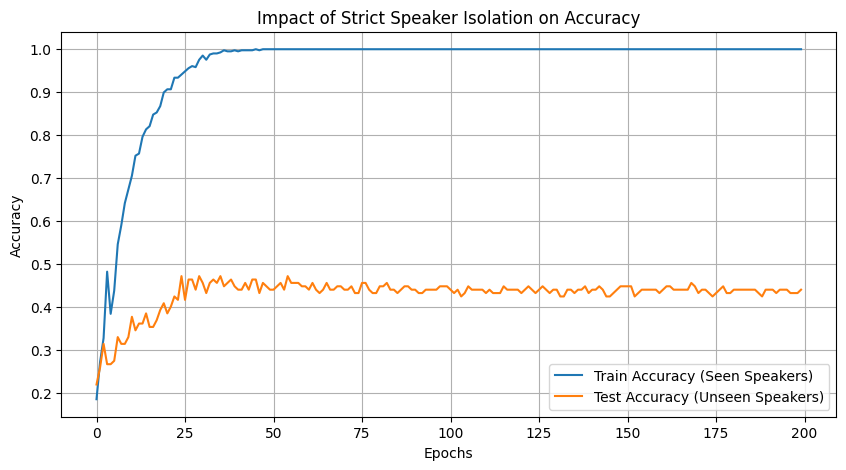

In [4]:
history = model_emodb_diff_speakers.fit(
    X_train, Y_train,
    epochs=200,          # [cite: 624]
    batch_size=64,       # [cite: 623]
    validation_data=(X_test, Y_test),
    verbose=1
)

# ==========================================
# 6. RESULTS ANALYSIS
# ==========================================
test_loss, test_acc = model_emodb_diff_speakers.evaluate(X_test, Y_test, verbose=0)

print("\n================================================")
print(f"RESULTS: STRICT SPEAKER INDEPENDENCE (Standardized)")
print(f"Strict Speaker Accuracy (Your Result): {test_acc*100:.2f}%")
print("================================================")

# Plotting the Generalization Gap
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy (Seen Speakers)')
plt.plot(history.history['val_accuracy'], label='Test Accuracy (Unseen Speakers)')
plt.title('Impact of Strict Speaker Isolation on Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**FOR EMODB DATASET, THEIR TRAIN ACCURACY IS CLOSE TO 100% AS IN THE PAPER HOWEVER WHEN THE TRAIN TEST SPLIT BASED ON SPEAKER ID, VALIDATION ACCCURACY DROPS ALL THE WAY TO 40%**

# **RAVDESS**

In [ ]:
import os
import numpy as np
import librosa
import scipy.stats
import pywt
from scipy.signal import lfilter
from tqdm import tqdm

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
TRAIN_PATH = "/content/drive/MyDrive/DeepLearning/External/RAVDESS Emotional Speech Audio/audio_speech_actors_01-24/"
TEST_PATH  = "/content/drive/MyDrive/DeepLearning/External/RAVDESS Emotional Speech Audio/Test/"
OUTPUT_PATH = "ravdess_processed_data/"

# RAVDESS specific mapping
# We merge 1 (Neutral) and 2 (Calm) -> 0
EMOTION_MAP = {
    1: 0, # Neutral -> Neutral
    2: 0, # Calm    -> Neutral
    3: 1, # Happy   -> Happy
    4: 2, # Sad     -> Sad
    5: 3, # Angry   -> Angry
    6: 4, # Fear    -> Fear
    7: 5, # Disgust -> Disgust
    8: 6  # Surprise-> Surprise
}

# ==========================================
# 2. FEATURE EXTRACTOR
# ==========================================
def extract_bhangale_features(audio_path):
    """
    Extracts the exact 715-dim feature vector described in Bhangale et al. (2023).
    """
    # Load audio, Resample to 16kHz
    try:
        y, sr = librosa.load(audio_path, sr=16000)
    except Exception as e:
        print(f"Error reading file: {audio_path}")
        return None

    # Standardize to 4 seconds (64000 samples)
    target_length = 64000
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)))
    else:
        y = y[:target_length]

    # Pre-emphasis filter
    y = lfilter([1, -0.97], [1], y)

    # Frame Settings: 40ms window, 50% overlap
    n_fft = 640
    hop_length = 320

    # --- A. TIME-SERIES FEATURES (Length 199 each) ---
    zcr = _fix_length(librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length)[0], 199)
    centroid = _fix_length(librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)[0], 199)
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    kurtosis = _fix_length(scipy.stats.kurtosis(S, axis=0), 199)

    # --- B. STATIC FEATURES ---
    # MFCC (39)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
    mfcc_combined = np.concatenate((mfcc, librosa.feature.delta(mfcc), librosa.feature.delta(mfcc, order=2)), axis=0)
    mfcc_global = np.mean(mfcc_combined, axis=1)

    # Scalars & Stats
    rms_global = np.array([np.mean(librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)[0])])
    rolloff_global = np.array([np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)[0])])

    # LPCC (13)
    lpc_coeffs = librosa.lpc(y, order=13)
    lpcc_global = lpc_coeffs[1:]
    if len(lpcc_global) < 13: lpcc_global = np.pad(lpcc_global, (0, 13-len(lpcc_global)))

    # Wavelet Packet Transform (56)
    wp = pywt.WaveletPacket(data=y, wavelet='db2', mode='symmetric', maxlevel=3)
    wpt_features = []
    for node in wp.get_level(3, 'natural'):
        d = node.data
        wpt_features.extend([np.mean(d), np.median(d), np.std(d), np.var(d), scipy.stats.skew(d), scipy.stats.kurtosis(d), np.sum(d**2)])
    wpt_global = np.array(wpt_features)

    # Voice Quality (3) & Formants (5)
    f0, _, _ = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    f0 = f0[~np.isnan(f0)]
    pitch_val = np.mean(f0) if len(f0) > 0 else 0.0
    jitter = (np.mean(np.abs(np.diff(f0))) / pitch_val) if pitch_val > 0 else 0.0
    shimmer = 0.0
    formants_vec = np.zeros(5)
    vq_features = np.array([jitter, shimmer, pitch_val])

    # Concatenate
    return np.concatenate([mfcc_global, rms_global, zcr, centroid, lpcc_global, wpt_global, rolloff_global, kurtosis, vq_features, formants_vec])

def _fix_length(arr, target_len):
    if len(arr) < target_len: return np.pad(arr, (0, target_len - len(arr)))
    return arr[:target_len]

# ==========================================
# 3. DIRECTORY PROCESSOR (GENERIC)
# ==========================================
def process_directory(base_path, output_prefix):
    """
    Scans a RAVDESS directory structure (Actor folders), extracts features, and saves X/Y.
    """
    X_list = []
    Y_list = []

    print(f"\n--- Scanning {output_prefix} Directory ---")

    if not os.path.exists(base_path):
        print(f"Error: Path not found {base_path}")
        return

    # 1. Gather all file paths first (for a clean progress bar)
    all_file_paths = []

    # Get actor folders
    actor_folders = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

    print(f"Found {len(actor_folders)} sub-directories (Actors). Gathering files...")

    for actor in actor_folders:
        actor_path = os.path.join(base_path, actor)
        files = [f for f in os.listdir(actor_path) if f.endswith('.wav')]
        for f in files:
            full_path = os.path.join(actor_path, f)
            all_file_paths.append(full_path)

    print(f"Total files to process: {len(all_file_paths)}")

    # 2. Process Files with TQDM
    for file_path in tqdm(all_file_paths, desc=f"Processing {output_prefix}", unit="file"):
        file_name = os.path.basename(file_path)

        try:
            # Parse Filename: 03-01-06-01-02-01-24.wav
            parts = file_name.split('.')[0].split('-')

            if len(parts) < 3:
                continue

            emotion_code = int(parts[2]) # 3rd number is emotion

            if emotion_code not in EMOTION_MAP:
                continue

            label = EMOTION_MAP[emotion_code]

            # Extract
            features = extract_bhangale_features(file_path)

            if features is not None and features.shape[0] == 715:
                X_list.append(features)
                Y_list.append(label)

        except Exception as e:
            tqdm.write(f"Error processing {file_name}: {e}")

    # 3. Save
    X = np.array(X_list)
    Y = np.array(Y_list)

    # Reshape for 1D CNN: (Batch, 715, 1)
    if X.shape[0] > 0:
        X = X[..., np.newaxis]

    print(f"Saving {output_prefix} data...")
    print(f"X Shape: {X.shape}")
    print(f"Y Shape: {Y.shape}")

    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

    np.save(os.path.join(OUTPUT_PATH, f"X_{output_prefix}.npy"), X)
    np.save(os.path.join(OUTPUT_PATH, f"Y_{output_prefix}.npy"), Y)

# ==========================================
# 4. EXECUTION
# ==========================================
if __name__ == "__main__":
    # Process TRAIN folder
    process_directory(TRAIN_PATH, "train_ravdess")

    # Process TEST folder
    process_directory(TEST_PATH, "test_ravdess")

    print("\nAll processing complete.")